In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [88]:
# Definimos los parámetros del modelo
alpha = .8   # Tasa de crecimiento de la vegetación
beta = 0.05   # Tasa de consumo de vegetación por las presas
gamma = 0.1   # Competencia intraespecífica en la vegetación
delta = 0.01  # Crecimiento de presas debido a la vegetación
epsilon = 0.05 # Depredación de presas por los depredadores
zeta = 0.005  # Crecimiento de depredadores debido a las presas
eta = 0.01     # Mortalidad natural de los depredadores

In [89]:
# Condiciones iniciales: Vegetación, Presas y Depredadores
V0, P0, D0 = alpha/gamma, 5, 2
y0_e = [V0, P0, D0]
y0   = [P0, D0]

# Intervalo de tiempo para la simulación
t_span = (0, 1500)
t_eval = np.linspace(*t_span, 1000)

In [90]:
# Definimos las ecuaciones diferenciales
def Lotka_Volterra(t, y):
    P, D = y
    dPdt = P * (delta * V0 - epsilon * D)
    dDdt = D * (zeta * P - eta)
    return [dPdt, dDdt]

def extendido(t, y):
    V, P, D = y
    dVdt = V * (alpha - beta * P - gamma * V)
    dPdt = P * (delta * V - epsilon * D)
    dDdt = D * (zeta * P - eta)
    return [dVdt, dPdt, dDdt]

In [91]:
# Resolver los sistemas de ecuaciones diferenciales
sol = solve_ivp(Lotka_Volterra, t_span, y0, t_eval=t_eval, method='RK45')

sol_e = solve_ivp(extendido, t_span, y0_e, t_eval=t_eval, method='RK45')

In [92]:
# Extraer soluciones
t = sol.t
P, D = sol.y

t_e = sol_e.t
V_e, P_e, D_e = sol_e.y

In [93]:
V_eq = (alpha - beta * (eta / zeta)) / gamma
P_eq = eta / zeta
D_eq = (delta * (alpha - beta * (eta / zeta)) / gamma) / epsilon

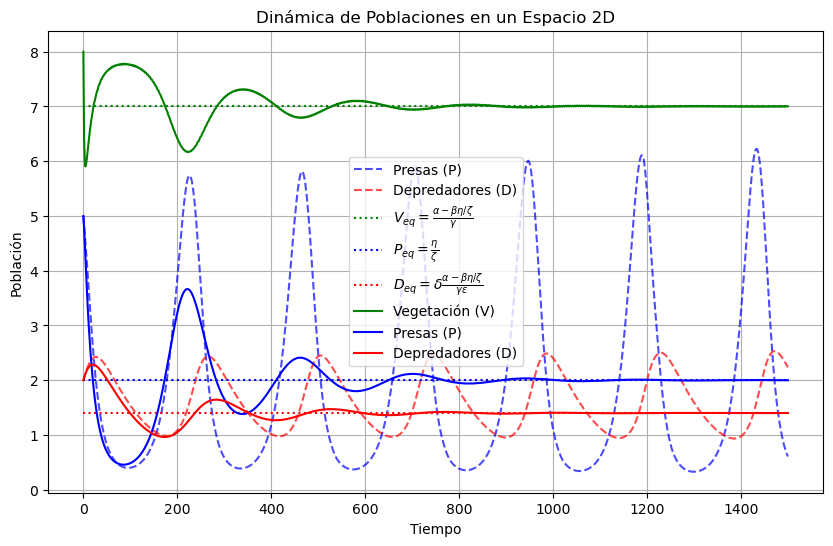

In [94]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
#Lotka-Volterra
plt.plot(t, P, '--', label="Presas (P)", color='blue', alpha=0.7)
plt.plot(t, D, '--', label="Depredadores (D)", color='red', alpha=0.7)
#Punto de equilibrio
plt.plot(t_e, t_e*0+V_eq, ':', label=r"$V_{eq}=\frac{\alpha-\beta\eta/\zeta}{\gamma}$", color='green')
plt.plot(t_e, t_e*0+P_eq, ':', label=r"$P_{eq}=\frac{\eta}{\zeta}$", color='blue')
plt.plot(t_e, t_e*0+D_eq, ':', label=r"$D_{eq}=\delta\frac{\alpha-\beta\eta/\zeta}{\gamma\epsilon}$", color='red')
#Modelo extendido
plt.plot(t_e, V_e, label="Vegetación (V)", color='green')
plt.plot(t_e, P_e, label="Presas (P)", color='blue')
plt.plot(t_e, D_e, label="Depredadores (D)", color='red')

plt.xlabel("Tiempo")
plt.ylabel("Población")
plt.title("Dinámica de Poblaciones en un Espacio 2D")
plt.legend()
plt.grid()
plt.show()

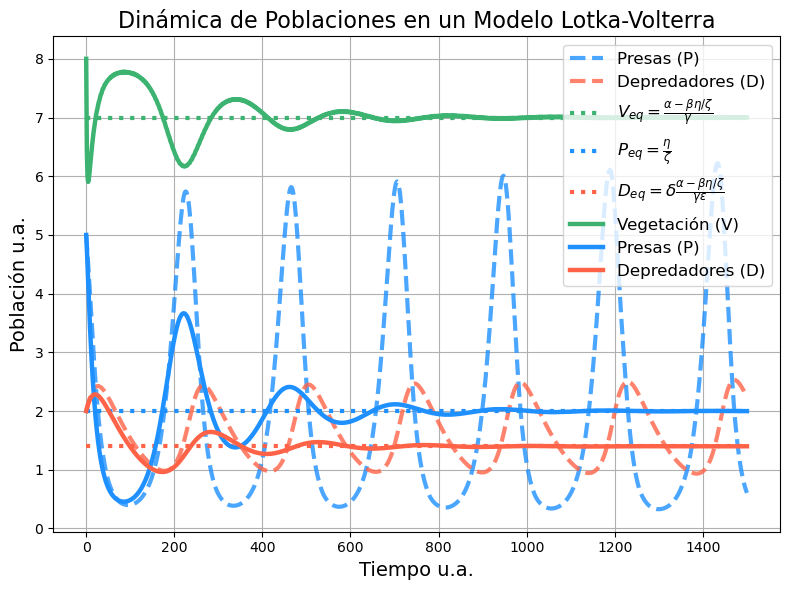

In [102]:
import matplotlib.pyplot as plt

# Define the colors
color_vege = '#3CB371'  # Soft green
color_presas = '#1E90FF'  # Soft blue
color_dep = '#FF6347'  # Soft red

plt.figure(figsize=(8, 6))

# Lotka-Volterra
plt.plot(t, P, '--', label="Presas (P)", color=color_presas, alpha=0.8, linewidth=3)
plt.plot(t, D, '--', label="Depredadores (D)", color=color_dep, alpha=0.8, linewidth=3)

# Punto de equilibrio
plt.plot(t_e, t_e*0+V_eq, ':', label=r"$V_{eq}=\frac{\alpha-\beta\eta/\zeta}{\gamma}$", color=color_vege, linewidth=3)
plt.plot(t_e, t_e*0+P_eq, ':', label=r"$P_{eq}=\frac{\eta}{\zeta}$", color=color_presas,linewidth=3)
plt.plot(t_e, t_e*0+D_eq, ':', label=r"$D_{eq}=\delta\frac{\alpha-\beta\eta/\zeta}{\gamma\epsilon}$", color=color_dep, linewidth=3)
# Modelo extendido
plt.plot(t_e, V_e, label="Vegetación (V)", color=color_vege, linewidth=3.2)
plt.plot(t_e, P_e, label="Presas (P)", color=color_presas, linewidth=3.2)
plt.plot(t_e, D_e, label="Depredadores (D)", color=color_dep, linewidth=3.2)

# Improve labels and title
plt.xlabel("Tiempo (u.a.)", fontsize=14)
plt.ylabel("Población (u.a.)", fontsize=14)
plt.title("Dinámica de Poblaciones en un Modelo Lotka-Volterra", fontsize=16)
plt.legend(fontsize=12, loc='upper right')

# Add grid for clarity
plt.grid(True)

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

